Period and shape recovery of periodic variables for Vera C. Rubin Observatory LSST

In [8]:
"""
Created for Cadence Note Call 2021
@author: Marcella Di Criscienzo, Silvio Leccia and Vittorio Braga
tested on AstroDataLab
"""

from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from statistics import median
from scipy.signal import argrelextrema
import lsst.sims.maf.utils.astrometryUtils 
import lsst.sims.maf.db.opsimDatabase
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.batches
import lsst.sims.maf.db as db
from lsst.sims.maf.utils import m52snr
from gatspy import periodic
import pandas as pd
from SaturationStacker import SaturationStacker
#import all

import readLCTeo
import LCteoWithLSST
import plottingLC
import LcModeling3
import qualityLc

In [9]:
#Example with Carina
ra_Ca = [100.402888]
dec_Ca = [-50.966196]
distMod_Ca=20.11
ebv_Ca=0.06


#**************Here make the decision**********
ra_TARGET=ra_Ca 
dec_TARGET=dec_Ca
distMod=distMod_Ca  #distanza della LMCLMC138
ebv=ebv_Ca


In [10]:
#Choose the variable(RRab.csv,RRc.csv,CEF1.csv,CEF2.csv,LPV1.csv,LPV2.csv), nHarmonics for the final fit of Light Curve  and the range of LombScargle


folder_marcella='/dlusers/dicrisci/GruppoMAF/CADENCENOTE/TEMPLATE/'
filename=folder_marcella+'RRab.csv'


output=readLCTeo.ReadTeoSim(filename,distMod,ebv)
period_model=output['period']/86400.

nHar=4

min_points_per_band=2


# FOR RRLS and CEF1 use 
minper_optimize=.2
maxper_optimize=2
minper_plot=.2
maxper_plot=2

# FOR CEF2  use 
#minper_optimize=.2
#maxper_optimize=50
#minper_plot=.2
#maxper_plot=50

# FOR LPV1  use 
#minper_optimize=.2
#maxper_optimize=1000
#minper_plot=.2
#maxper_plot=1000

#FOR LPV2 use 
#minper_optimize=10
#maxper_optimize=2000
#minper_plot=10
#maxper_plot=2000



print('Model=')
print(filename)
print('Period (days) of the Model=')
print(period_model)
def initmeans(meanu,meang,meanr,meani,meanz,meany):
     return np.asarray([meanu,meang,meanr,meani,meanz,meany])
medie=initmeans(output['meanu'], output['meang'], output['meanr'], output['meani'], output['meanz'], output['meany'])
print('Mean Magnitude (ugrizy) of the Model at distMod and E(B-V)=')
print(medie)


Model=
/dlusers/dicrisci/GruppoMAF/CADENCENOTE/TEMPLATE/RRab.csv
Period (days) of the Model=
0.605520833333333
Mean Magnitude (ugrizy) of the Model at distMod and E(B-V)=
[21.91121551 20.85985875 20.85319692 20.62690914 20.62793971 20.61504246]


In [11]:
#Choose OpSim (deselect runName and corresponding dbFile)
#path from Data Astrolab
#Example baseline_v1.5_10yrs.db

runName = 'baseline_v1.5_10yrs.db'
dbFile = '/sims_maf/fbs_1.5/baseline/baseline_v1.5_10yrs.db'



opsdb = db.OpsimDatabase(dbFile)
outDir = 'Results_'+str(runName)+'RRabinCarina_sigma1'
resultsDb = db.ResultsDb(outDir=outDir)
#per sapere che versione di Opsim ha generato la baseline
version=lsst.sims.maf.db.opsimDatabase.testOpsimVersion(dbFile, driver='sqlite', host=None, port=None)
print(runName)


baseline_v1.5_10yrs.db


*******0)I am inizializing*********
******************START THE ANALYSIS******************
******************YEAR 2
*******1)I am building the simulated light curve*********
Querying database SummaryAllProps with constraint night between 0 and 730 for columns ['skyBrightness', 'fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'fieldDec', 'airmass', 'seeingFwhmEff', 'visitExposureTime', 'night', 'filter', 'numExposures']
Found 427513 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
169 Observations total at this point (All SNR levels)
169not saturated 
%i not saturated 169
ALL and not saturated u
14 14
ALL and not saturated g
15 15
ALL and not saturated r
34 34
ALL and not saturated i
36 36
ALL and not saturated z
33 33
ALL and not saturated y
37 37
Dimesion in phase of the biggest hole in light curve 
holeDim_u
0.2727684386134257
holeDim_g
0.6258571299282778
holeDim_r
0.2268657629616655
holeDim_i
0.0964066769611378
holeD

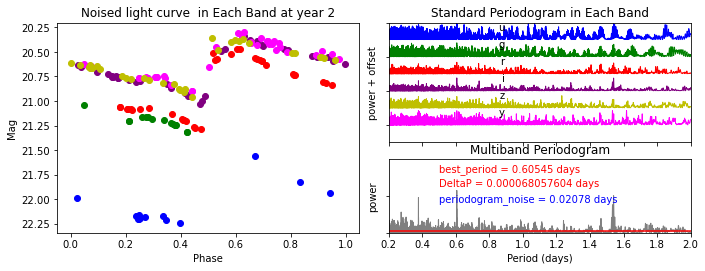

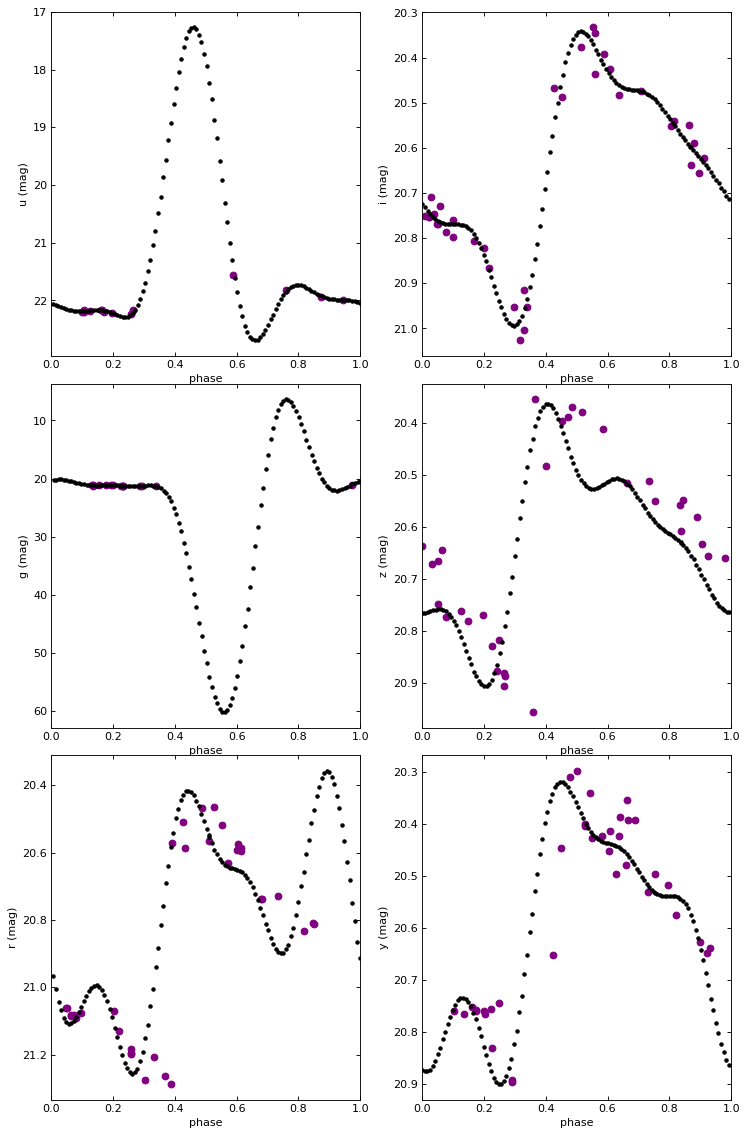

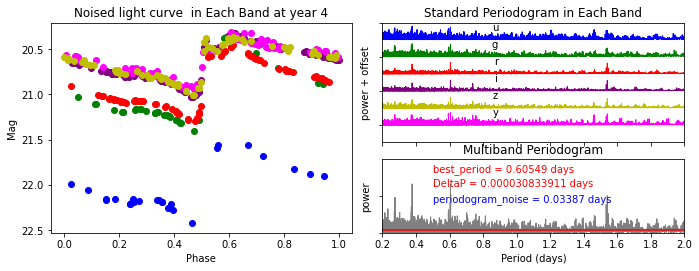

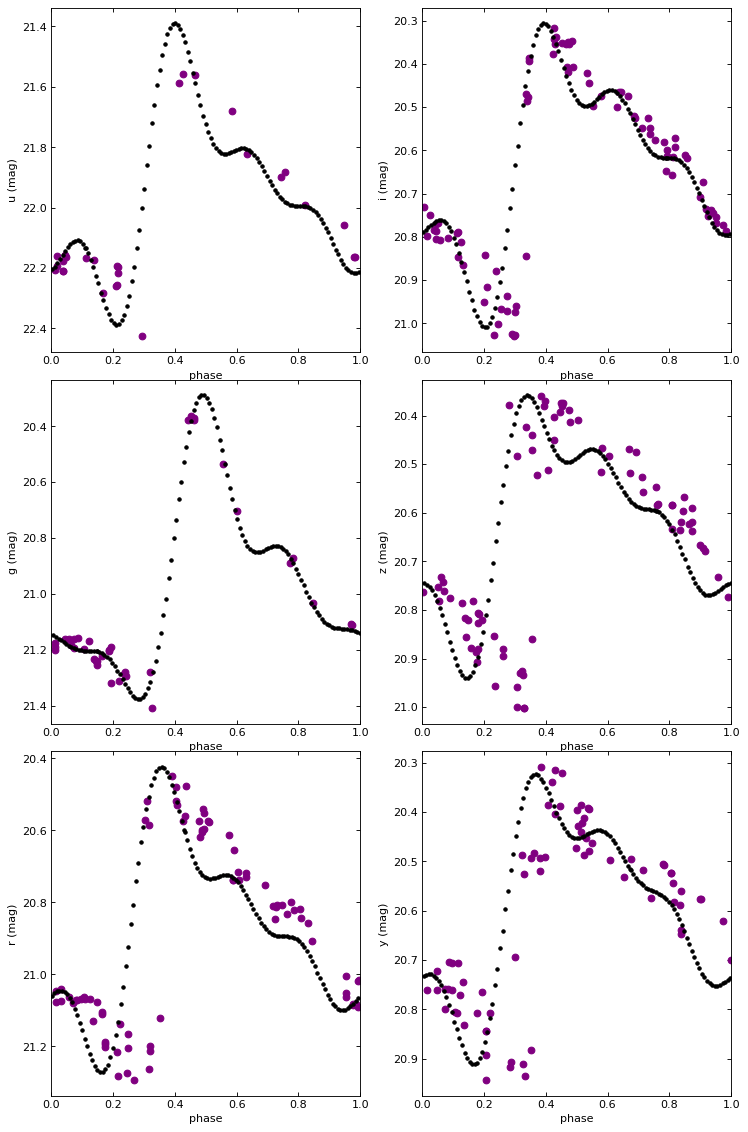

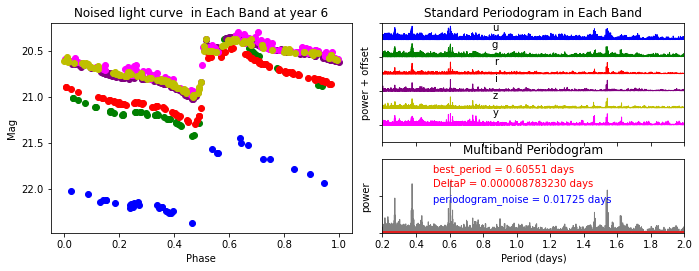

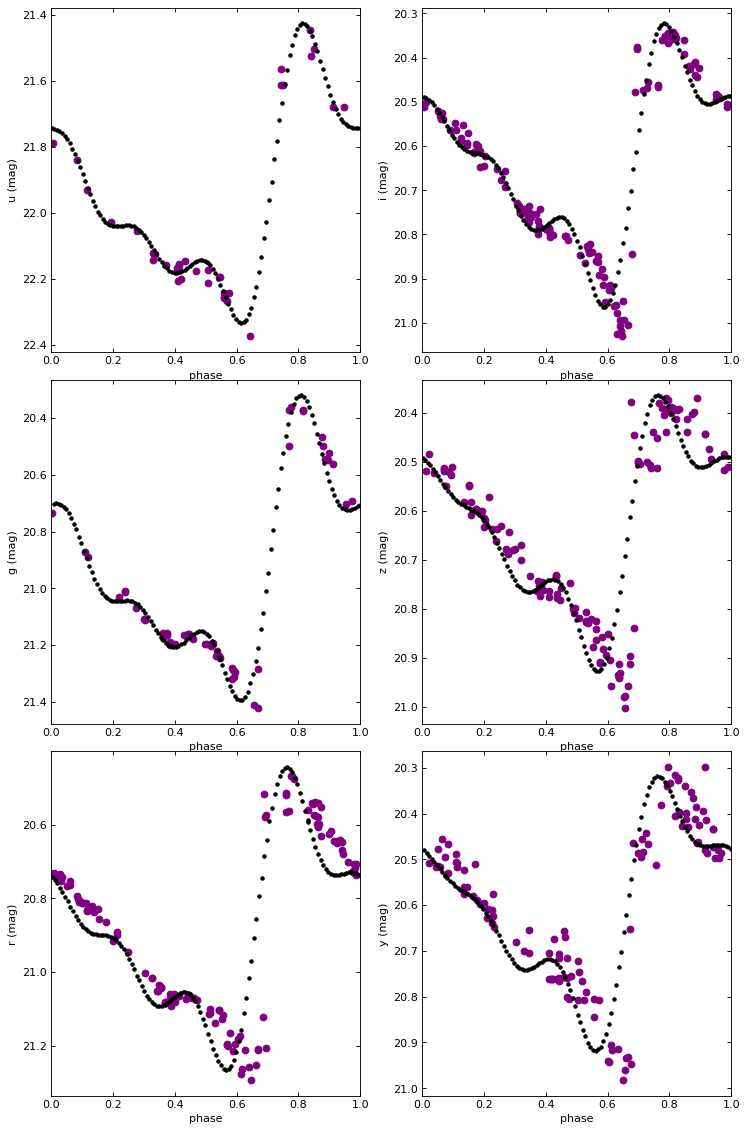

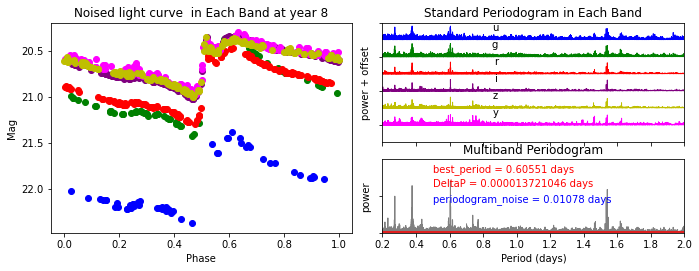

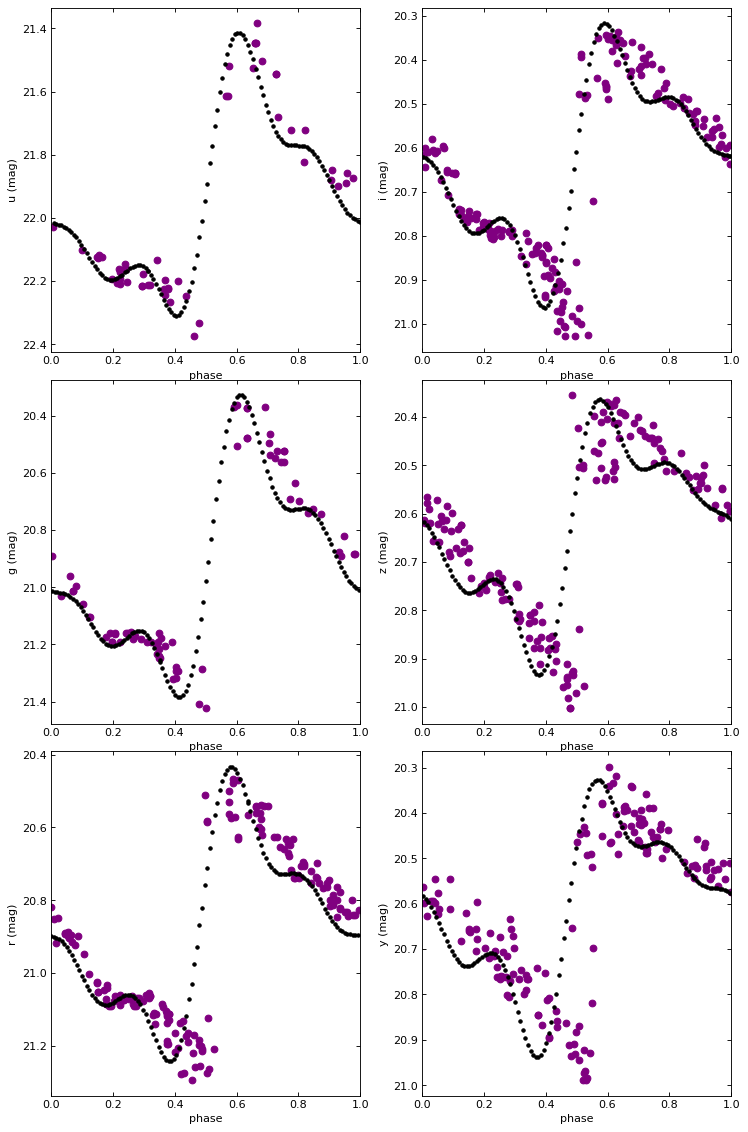

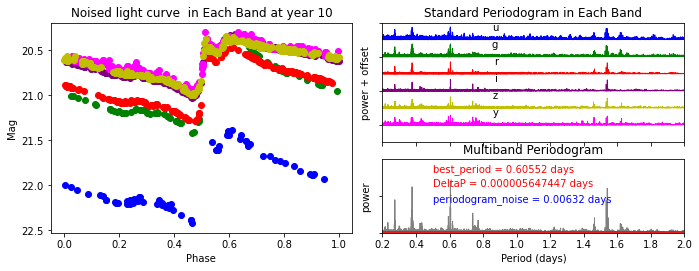

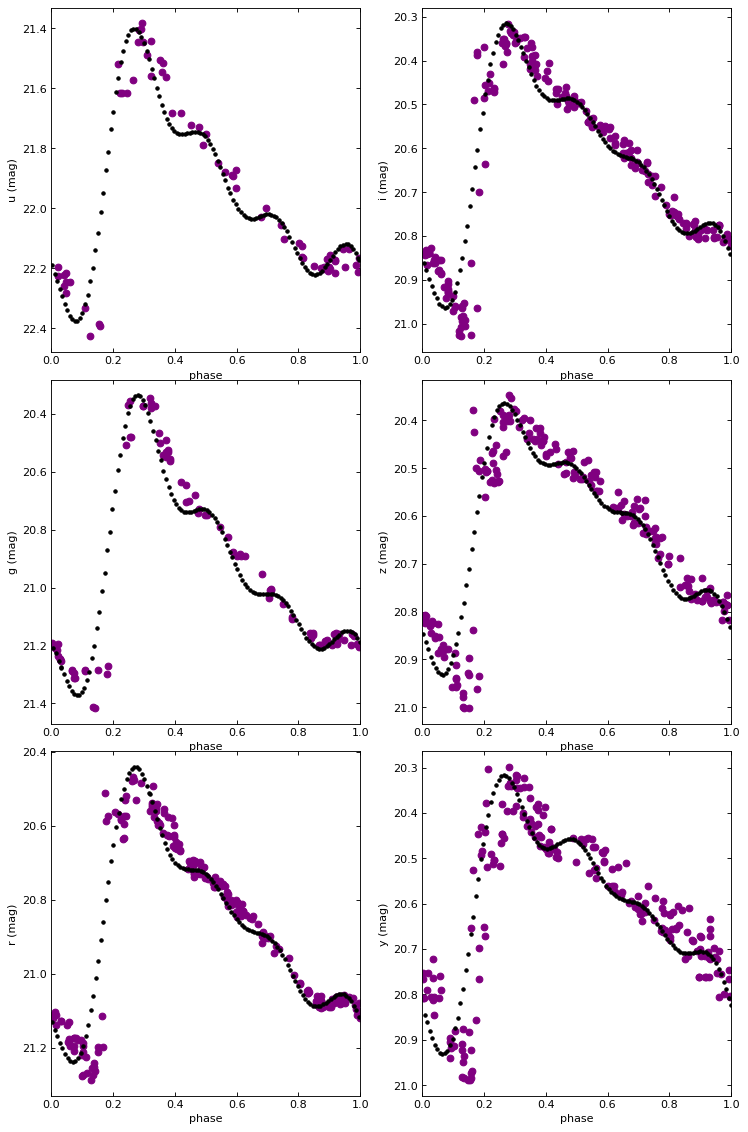

In [12]:
#This cell make a lot of things.In particular for each year 
#1)build the simulated Light Curve at the choosen slicerpoint
#2)make  Multifilter LombScargle with Gatspy
#3)make a fit of LC


from collections import defaultdict
from collections import OrderedDict

colors = {'u': 'b','g': 'g','r': 'r',
          'i': 'purple',"z": 'y',"y": 'magenta'}




periods = np.linspace(minper_optimize, maxper_optimize,50000)

#Sql
year_start=0
#array_year_finish=[10]
array_year_finish=[2,4,6,8,10]


slicer=slicers.UserPointsSlicer(ra=ra_TARGET,dec=dec_TARGET, radius=1.75)
metric=metrics.PassMetric(cols=['observationStartMJD', 'fiveSigmaDepth', 'filter', 
                                'fieldRA', 'night','visitExposureTime','numExposures',
                               'skyBrightness','seeingFwhmEff','airmass'])
print('*******0)I am inizializing*********')
sql_dict={}
sql_dict=OrderedDict()
bundle_dict={}
bundle_dict=OrderedDict()
bgroup_dict={}
bgroup_dict=OrderedDict()
mv_dict={}
mv_dict=OrderedDict()
snr_dict={}
snr_dict=OrderedDict()

time_lsst_dict={}
time_lsst_dict=OrderedDict()
filters_lsst_dict={}
filters_lsst_dict=OrderedDict()
satlevel_lsst_dict={}
satlevel_lsst_dict=OrderedDict()
fivesigmadepth_lsst_dict={}
fivesigmadepth_lsst_dict=OrderedDict()
ra_lsst_dict={}
ra_lsst_dict=OrderedDict()
dec_lsst_dict={}
dec_lsst_dict=OrderedDict()

LcTeoLSST_dict={}
LcTeoLSST_dict=OrderedDict()
LcTeoLSST_noised_dict={}
LcTeoLSST_noised_dict=OrderedDict()

filters_dict={}
filters_dict=OrderedDict()

phase_all_dict={}
phase_all_dict=OrderedDict()
time_all_dict={}
time_all_dict=OrderedDict()
mag_all_dict={}
mag_all_dict=OrderedDict()
noise_all_dict={}
noise_all_dict=OrderedDict()
dmag_all_dict={}
dmag_all_dict=OrderedDict()
n_allpoints_dict={}
n_allpoints_dict=OrderedDict()
model_dict={}
model_dict=OrderedDict()

P_dict={}
P_dict=OrderedDict()
LS_multi_dict={}
LS_multi_dict=OrderedDict()
P_multi_dict={}
P_multi_dict=OrderedDict()
fitLS_multi_dict={}
fitLS_multi_dict=OrderedDict()

peak_snr_array=[]
peak_snr_mean_array=[]
best_per_array=[]
noise_array=[]
noise_array_mean=[]


holeDim_u=[]
N_hole_u=[]
holeDim_u_array=[]
N_hole_u_array=[]

holeDim_g=[]
N_hole_g=[]
holeDim_g_array=[]
N_hole_g_array=[]

holeDim_r=[]
N_hole_r=[]
holeDim_r_array=[]
N_hole_r_array=[]

holeDim_i=[]
N_hole_i=[]
holeDim_i_array=[]
N_hole_i_array=[]

holeDim_z=[]
N_hole_z=[]
holeDim_z_array=[]
N_hole_z_array=[]

holeDim_y=[]
N_hole_y=[]
holeDim_y_array=[]
N_hole_y_array=[]

diff=[]
diff_array=[]
DeltaMean_u=[]
DeltaMean_u_array=[]
DeltaMean_g=[]
DeltaMean_g_array=[]
DeltaMean_r=[]
DeltaMean_r_array=[]
DeltaMean_i=[]
DeltaMean_i_array=[]
DeltaMean_z=[]
DeltaMean_z_array=[]
DeltaMean_y=[]
DeltaMean_y_array=[]
DeltaAmpl_u=[]
DeltaAmpl_u_array=[]
DeltaAmpl_g=[]
DeltaAmpl_g_array=[]
DeltaAmpl_r=[]
DeltaAmpl_r_array=[]
DeltaAmpl_i=[]
DeltaAmpl_i_array=[]
DeltaAmpl_z=[]
DeltaAmpl_z_array=[]
DeltaAmpl_y=[]
DeltaAmpl_y_array=[]

Chi_u=[]
Chi_u_array=[]
Chi_g=[]
Chi_g_array=[]
Chi_r=[]
Chi_r_array=[]
Chi_i=[]
Chi_i_array=[]
Chi_z=[]
Chi_z_array=[]
Chi_y=[]
Chi_y_array=[]




n_obs_u=[]
n_obs_g=[]
n_obs_r=[]
n_obs_i=[]
n_obs_z=[]
n_obs_y=[]

nns_obs_u=[]
nns_obs_g=[]
nns_obs_r=[]
nns_obs_i=[]
nns_obs_z=[]
nns_obs_y=[]

minper_optimize2=0.75*period_model
maxper_optimize2_init=1.25*period_model


satStacker = SaturationStacker()

print('******************START THE ANALYSIS******************')
for year_finish in array_year_finish:

    print('******************YEAR {}'.format(year_finish))
    print('*******1)I am building the simulated light curve*********')
    key_sql_i='sql_{}'.format(year_finish)
    sql_dict[key_sql_i]=['night between %d and %d' % (365.25 * year_start, 365.25 * year_finish)]    

    key_bundle_i='bundle_{}'.format(year_finish)
    bundle_dict[key_bundle_i]=metricBundles.MetricBundle(metric, slicer, sql_dict[key_sql_i][0], runName=runName)
    
    key_bgroup_i='bgroup_{}'.format(year_finish)
    bgroup_dict[key_bgroup_i]=metricBundles.MetricBundleGroup(
    {0: bundle_dict[key_bundle_i]}, opsdb, outDir=outDir, resultsDb=resultsDb)
    (bgroup_dict[key_bgroup_i]).runAll()
    
    key_mv_i='mv_{}'.format(year_finish)
    mv_dict[key_mv_i] = (bundle_dict[key_bundle_i]).metricValues[0]
    mv_dict[key_mv_i] = satStacker.run(mv_dict[key_mv_i])

    #Definition of the array of times and filters
    key_time_lsst_i='time_lsst_{}'.format(year_finish)
    time_lsst_dict[key_time_lsst_i]=np.asarray(mv_dict[key_mv_i]['observationStartMJD'])+np.asarray(mv_dict[key_mv_i]['visitExposureTime']/2./86400.)
    
    key_filters_lsst_i='filters_lsst_{}'.format(year_finish)
    filters_lsst_dict[key_filters_lsst_i]=np.asarray(mv_dict[key_mv_i]['filter'])
    
    key_satlevel_lsst_i='satlevel_lsst_{}'.format(year_finish)
    satlevel_lsst_dict[key_satlevel_lsst_i]=np.asarray(mv_dict[key_mv_i]['saturation_mag'])
    
    key_fivesigmadepth_lsst_i='fivesigmadepth_lsst_{}'.format(year_finish)
    fivesigmadepth_lsst_dict[key_fivesigmadepth_lsst_i]=np.asarray(mv_dict[key_mv_i]['fiveSigmaDepth'])
    
    key_ra_lsst_i='ra_lsst_{}'.format(year_finish)
    ra_lsst_dict[key_ra_lsst_i]=np.asarray(mv_dict[key_mv_i]['fieldRA'])
    
    key_dec_lsst_i='dec_lsst_{}'.format(year_finish)
    dec_lsst_dict[key_dec_lsst_i]=np.asarray(mv_dict[key_mv_i]['fieldDec'])
    
    ind_sort=np.argsort(time_lsst_dict[key_time_lsst_i])
    
    time_lsst_dict[key_time_lsst_i]=time_lsst_dict[key_time_lsst_i][ind_sort]
    filters_lsst_dict[key_filters_lsst_i]=filters_lsst_dict[key_filters_lsst_i][ind_sort]
    satlevel_lsst_dict[key_satlevel_lsst_i]=satlevel_lsst_dict[key_satlevel_lsst_i][ind_sort]
    ra_lsst_dict[key_ra_lsst_i]=ra_lsst_dict[key_ra_lsst_i][ind_sort]
    dec_lsst_dict[key_dec_lsst_i]=dec_lsst_dict[key_dec_lsst_i][ind_sort] 
    fivesigmadepth_lsst_dict[key_fivesigmadepth_lsst_i]=fivesigmadepth_lsst_dict[key_fivesigmadepth_lsst_i][ind_sort]
    ind_mv_u = np.where(filters_lsst_dict[key_filters_lsst_i] == 'u')
    sn_u=m52snr(output['meanu'],fivesigmadepth_lsst_dict[key_fivesigmadepth_lsst_i][ind_mv_u])
    ind_mv_g = np.where(filters_lsst_dict[key_filters_lsst_i]== 'g')
    sn_g=m52snr(output['meang'],fivesigmadepth_lsst_dict[key_fivesigmadepth_lsst_i][ind_mv_g])
    ind_mv_r = np.where(filters_lsst_dict[key_filters_lsst_i] == 'r')
    sn_r=m52snr(output['meanr'],fivesigmadepth_lsst_dict[key_fivesigmadepth_lsst_i][ind_mv_r])
    ind_mv_i = np.where(filters_lsst_dict[key_filters_lsst_i] == 'i')
    sn_i=m52snr(output['meani'],fivesigmadepth_lsst_dict[key_fivesigmadepth_lsst_i][ind_mv_i])
    ind_mv_z = np.where(filters_lsst_dict[key_filters_lsst_i] == 'z')
    sn_z=m52snr(output['meanz'],fivesigmadepth_lsst_dict[key_fivesigmadepth_lsst_i][ind_mv_z])
    ind_mv_y = np.where(filters_lsst_dict[key_filters_lsst_i] == 'y')
    sn_y=m52snr(output['meany'],fivesigmadepth_lsst_dict[key_fivesigmadepth_lsst_i][ind_mv_y])

    key_snr_i='snr_{}'.format(year_finish)
    snr_dict[key_snr_i]={'u':sn_u,'g':sn_g,'r':sn_r,'i':sn_i,'z':sn_z,'y':sn_y}
    del(sn_u,sn_g,sn_r,sn_i,sn_z,sn_y)
        
    key_LcTeoLSST_i='LcTeoLSST_{}'.format(year_finish)
    LcTeoLSST_dict[key_LcTeoLSST_i]=LCteoWithLSST.generateLC(time_lsst_dict[key_time_lsst_i],
                        filters_lsst_dict[key_filters_lsst_i],output)
    key_LcTeoLSST_noised_i='LcTeoLSST_noised_{}'.format(year_finish)
    LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]=LCteoWithLSST.noising(
                        LcTeoLSST_dict[key_LcTeoLSST_i],
                        snr_dict[key_snr_i],1)
    
    key_filters_i='filters_{}'.format(year_finish)
    filters_dict[key_filters_i] = np.unique(filters_lsst_dict[key_filters_lsst_i])
    

        
    n_temp=(np.where(filters_lsst_dict[key_filters_lsst_i] == 'u'))[0].size
    n_obs_u.append(n_temp)
    n_temp=(np.where(filters_lsst_dict[key_filters_lsst_i] == 'g'))[0].size
    n_obs_g.append(n_temp)
    n_temp=(np.where(filters_lsst_dict[key_filters_lsst_i] == 'r'))[0].size
    n_obs_r.append(n_temp)
    n_temp=(np.where(filters_lsst_dict[key_filters_lsst_i] == 'i'))[0].size
    n_obs_i.append(n_temp)
    n_temp=(np.where(filters_lsst_dict[key_filters_lsst_i] == 'z'))[0].size
    n_obs_z.append(n_temp)
    n_temp=(np.where(filters_lsst_dict[key_filters_lsst_i] == 'y'))[0].size
    n_obs_y.append(n_temp)
        

    ind_notsaturated=(np.where(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['mag_all'] > satlevel_lsst_dict[key_satlevel_lsst_i]))[0]
    ind_notsaturated_u=(np.where(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magu'] > satlevel_lsst_dict[key_satlevel_lsst_i][ind_mv_u]))[0]
    ind_notsaturated_g=(np.where(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magg'] > satlevel_lsst_dict[key_satlevel_lsst_i][ind_mv_g]))[0]
    ind_notsaturated_r=(np.where(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magr'] > satlevel_lsst_dict[key_satlevel_lsst_i][ind_mv_r]))[0]
    ind_notsaturated_i=(np.where(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magi'] > satlevel_lsst_dict[key_satlevel_lsst_i][ind_mv_i]))[0]
    ind_notsaturated_z=(np.where(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magz'] > satlevel_lsst_dict[key_satlevel_lsst_i][ind_mv_z]))[0]
    ind_notsaturated_y=(np.where(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magy'] > satlevel_lsst_dict[key_satlevel_lsst_i][ind_mv_y]))[0]
    


    
    filters1_init=filters_lsst_dict[key_filters_lsst_i]
    filters1=filters1_init[ind_notsaturated]
    num_obs=len(filters1)
#    print(filters1)
    
    ind_notsaturated_u2=(np.where(filters1=='u'))[0]
    ind_notsaturated_g2=(np.where(filters1=='g'))[0]
    ind_notsaturated_r2=(np.where(filters1=='r'))[0]
    ind_notsaturated_i2=(np.where(filters1=='i'))[0]
    ind_notsaturated_z2=(np.where(filters1=='z'))[0]
    ind_notsaturated_y2=(np.where(filters1=='y'))[0]
    
    ind_notsaturated_temp_u=ind_notsaturated[ind_notsaturated_u2]
    ind_notsaturated_temp_g=ind_notsaturated[ind_notsaturated_g2]
    ind_notsaturated_temp_r=ind_notsaturated[ind_notsaturated_r2]
    ind_notsaturated_temp_i=ind_notsaturated[ind_notsaturated_i2]
    ind_notsaturated_temp_z=ind_notsaturated[ind_notsaturated_z2]
    ind_notsaturated_temp_y=ind_notsaturated[ind_notsaturated_y2]
        

    if len(ind_notsaturated_u) <=min_points_per_band:
        ind_notsaturated_u=[]
        ind_notsaturated = np.asarray([ele for ele in ind_notsaturated if ele not in ind_notsaturated_temp_u])


    if len(ind_notsaturated_g) <=min_points_per_band:
        ind_notsaturated_g=[]
        ind_notsaturated = np.asarray([ele for ele in ind_notsaturated if ele not in ind_notsaturated_temp_g])

    if len(ind_notsaturated_r) <=min_points_per_band:
        ind_notsaturated_r=[]
        ind_notsaturated = np.asarray([ele for ele in ind_notsaturated if ele not in ind_notsaturated_temp_r])

    if len(ind_notsaturated_i) <=min_points_per_band:
        ind_notsaturated_i=[]
        ind_notsaturated = np.asarray([ele for ele in ind_notsaturated if ele not in ind_notsaturated_temp_i])

    if len(ind_notsaturated_z) <=min_points_per_band:
        ind_notsaturated_z=[]
        ind_notsaturated = np.asarray([ele for ele in ind_notsaturated if ele not in ind_notsaturated_temp_z])

    if len(ind_notsaturated_y) <=min_points_per_band:
        ind_notsaturated_y=[]
        ind_notsaturated = np.asarray([ele for ele in ind_notsaturated if ele not in ind_notsaturated_temp_y])

    

 
    nns_temp=(np.where(filters_lsst_dict[key_filters_lsst_i][ind_notsaturated] == 'u'))[0].size
    nns_obs_u.append(nns_temp)

    nns_temp=(np.where(filters_lsst_dict[key_filters_lsst_i][ind_notsaturated] == 'g'))[0].size
    nns_obs_g.append(nns_temp)

    nns_temp=(np.where(filters_lsst_dict[key_filters_lsst_i][ind_notsaturated] == 'r'))[0].size
    nns_obs_r.append(nns_temp)

    nns_temp=(np.where(filters_lsst_dict[key_filters_lsst_i][ind_notsaturated] == 'i'))[0].size
    nns_obs_i.append(nns_temp)

    nns_temp=(np.where(filters_lsst_dict[key_filters_lsst_i][ind_notsaturated] == 'z'))[0].size
    nns_obs_z.append(nns_temp)

    nns_temp=(np.where(filters_lsst_dict[key_filters_lsst_i][ind_notsaturated] == 'y'))[0].size
    nns_obs_y.append(nns_temp)
    
    
       

    if len(ind_notsaturated_y) <=min_points_per_band:

        ind_notsaturated_y=[]
        ind_notsaturated = np.asarray([ele for ele in ind_notsaturated if ele not in ind_notsaturated_temp_y])

    print('%i Observations total at this point (All SNR levels)' % (
        (filters_lsst_dict[key_filters_lsst_i]).size))
    print('%inot saturated ' % (
        (ind_notsaturated).size))
    
    print('%i not saturated {}'.format(len(ind_notsaturated)))

    print('ALL and not saturated u')
    print(len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magu']),len(ind_notsaturated_u))
    print('ALL and not saturated g')
    print(len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magg']),len(ind_notsaturated_g))
    print('ALL and not saturated r')
    print(len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magr']),len(ind_notsaturated_r))
    print('ALL and not saturated i')
    print(len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magi']),len(ind_notsaturated_i))
    print('ALL and not saturated z')
    print(len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magz']),len(ind_notsaturated_z))
    print('ALL and not saturated y')
    print(len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magy']),len(ind_notsaturated_y))
    
    
    
    
    #Here I Plot simulated (and noised with a given sigma (default 3))light curve at distMod  with template  from which is obtained (see FigALL_year)
    plottingLC.plotting_LSST('LC multipanel',output['phase'],output['u'],output['phase'],output['g'],
                             output['phase'],output['r'],output['phase'],output['i'],output['phase'],output['z'],
                             output['phase'],output['y'],
                             LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['phaseu'][ind_notsaturated_u],LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magu'][ind_notsaturated_u],
                             LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['phaseg'][ind_notsaturated_g],LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magg'][ind_notsaturated_g],
                             LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['phaser'][ind_notsaturated_r],LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magr'][ind_notsaturated_r],
                             LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['phasei'][ind_notsaturated_i],LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magi'][ind_notsaturated_i],
                             LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['phasez'][ind_notsaturated_z],LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magz'][ind_notsaturated_z],
                             LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['phasey'][ind_notsaturated_y],LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magy'][ind_notsaturated_y],
                            snr_dict[key_snr_i]['u'][ind_notsaturated_u],snr_dict[key_snr_i]['g'][ind_notsaturated_g],snr_dict[key_snr_i]['r'][ind_notsaturated_r],
                             snr_dict[key_snr_i]['i'][ind_notsaturated_i],snr_dict[key_snr_i]['z'][ind_notsaturated_z],snr_dict[key_snr_i]['y'][ind_notsaturated_y])
    plt.savefig(str(outDir)+'/figALL_year'+str(year_finish)+'.pdf')
    plt.close()

    
    warnings.filterwarnings("ignore")

    key_phase_all_i='phase_all_{}'.format(year_finish)
    phase_all_dict[key_phase_all_i]=LcTeoLSST_dict[key_LcTeoLSST_i]['phase_all'][ind_notsaturated]
    key_time_all_i='time_all_{}'.format(year_finish)
    time_all_dict[key_time_all_i]=LcTeoLSST_dict[key_LcTeoLSST_i]['time_all'][ind_notsaturated]
    key_mag_all_i='mag_all_{}'.format(year_finish)
    mag_all_dict[key_mag_all_i]=LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['mag_all'][ind_notsaturated]
    key_noise_all_i='noise_all_{}'.format(year_finish)
    noise_all_dict[key_noise_all_i]=LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['dmag_all'][ind_notsaturated]
    key_dmag_all_i='dmag_all_{}'.format(year_finish)
    dmag_all_dict[key_dmag_all_i]=LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['dmag_all'][ind_notsaturated]
    key_n_allpoints_i='n_allpoints_{}'.format(year_finish)
    
    n_allpoints_dict[key_n_allpoints_i]=len(phase_all_dict[key_phase_all_i])
    
    ind_notsaturated_dict={'ind_notsaturated_u':ind_notsaturated_u,'ind_notsaturated_g':ind_notsaturated_g,
'ind_notsaturated_r':ind_notsaturated_r,'ind_notsaturated_i':ind_notsaturated_i,
'ind_notsaturated_z':ind_notsaturated_z,'ind_notsaturated_y':ind_notsaturated_y}
 
    print('Dimesion in phase of the biggest hole in light curve ')
#oggetto che calcola i buchi sulla curva di luce 
    if len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timeu'][ind_notsaturated_u])<1:
        holeDim_u=1
        N_hole_u=999
    else:
        holeDim_u,N_hole_u=qualityLc.qualityCheck(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timeu'][ind_notsaturated_u],period_model,1,year_finish)
    print('holeDim_u')
    print(holeDim_u)
    holeDim_u_array.append(holeDim_u)
    N_hole_u_array.append(N_hole_u)
    
    
    if len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timeg'][ind_notsaturated_g])<1:
        holeDim_g=1
        N_hole_g=999
    else:
        holeDim_g,N_hole_g=qualityLc.qualityCheck(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timeg'][ind_notsaturated_g],period_model,1,year_finish)
    print('holeDim_g')
    print(holeDim_g)
    holeDim_g_array.append(holeDim_g)
    N_hole_g_array.append(N_hole_g)

    if len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timer'][ind_notsaturated_r])<1:
        holeDim_r=1
        N_hole_r=999
    else:
        holeDim_r,N_hole_r=qualityLc.qualityCheck(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timer'][ind_notsaturated_r],period_model,1,year_finish)
    print('holeDim_r')
    print(holeDim_r)
    holeDim_r_array.append(holeDim_r)
    N_hole_r_array.append(N_hole_r)
    
    if len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timei'][ind_notsaturated_i])<1:
        holeDim_i=1
        N_hole_i=999
    else:
        holeDim_i,N_hole_i=qualityLc.qualityCheck(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timei'][ind_notsaturated_i],period_model,1,year_finish)
    print('holeDim_i')
    print(holeDim_i)
    holeDim_i_array.append(holeDim_i)
    N_hole_i_array.append(N_hole_i)
                                                         
    if len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timez'][ind_notsaturated_z])<1:
        holeDim_z=1
        N_hole_z=999
    else:
        holeDim_z,N_hole_z=qualityLc.qualityCheck(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timez'][ind_notsaturated_z],period_model,1,year_finish)
    print('holeDim_z')
    print(holeDim_z)
    holeDim_z_array.append(holeDim_z)
    N_hole_z_array.append(N_hole_z)
    
    if len(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timey'][ind_notsaturated_y])<1:
        holeDim_y=1
        N_hole_y=999
    else:
        holeDim_y,N_hole_y=qualityLc.qualityCheck(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timey'][ind_notsaturated_y],period_model,1,year_finish)
    print('holeDim_y')
    print(holeDim_y)
    holeDim_y_array.append(holeDim_y)
    N_hole_y_array.append(N_hole_y)

 
    print('*********1)I am making the  LombScargle analysis with Gatspy ******')
    
    fig = plt.figure(figsize=(10, 4))
    gs = plt.GridSpec(5, 2, left=0.07, right=0.95, bottom=0.15,
                      wspace=0.1, hspace=0.6)
    ax = [  fig.add_subplot(gs[:, 0]),
          fig.add_subplot(gs[:-2, 1]),
          fig.add_subplot(gs[-2:, 1])]

    filters_observed=set(filters1)
    
       #Here I Plot the phased light curve with noise from m5s
    ax[0].set_xlabel('Phase')
    ax[0].set_ylabel('Mag')
    ax[0].set_title('Noised light curve  in Each Band at year '+str(year_finish), fontsize=12)
    for filterName in filters_dict[key_filters_i]:
        ax[0].scatter(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['phase'+filterName][ind_notsaturated_dict['ind_notsaturated_'+filterName]],
LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['mag'+filterName][ind_notsaturated_dict['ind_notsaturated_'+filterName]],c=colors[filterName], label=filterName)
          
    ax[0].invert_yaxis()
        
    maxper_optimize2=min([maxper_optimize2_init,max(time_all_dict[key_time_all_i])-min(time_all_dict[key_time_all_i])])
        
    key_model_i='model_{}'.format(year_finish)
    model_dict[key_model_i] = periodic.NaiveMultiband(BaseModel=periodic.LombScargleFast)
    
    
    #if(len(time_all_dict[key_time_all_i])>1 & len(mag_all_dict[key_mag_all_i])>1 &len(noise_all_dict[key_noise_all_i])>1) :
    (model_dict[key_model_i]).fit(time_all_dict[key_time_all_i], mag_all_dict[key_mag_all_i], noise_all_dict[key_noise_all_i], filters1)
    key_P_i='P_{}'.format(year_finish)
    P_dict[key_P_i] = (model_dict[key_model_i]).scores(periods)
    #else:
    #P_dict[key_P_i]=[999.]
    
    for i, band in enumerate('ugrizy'):
        n_temp=len((np.where(filters1 == band))[0])
        if n_temp >= 1:
            offset = 5 - i
            ax[1].plot(periods, P_dict[key_P_i][band] + offset, lw=1, c=colors[band])
        ax[1].text(0.89, 1 + offset, band, fontsize=10, ha='right', va='top')
        ax[1].set_title('Standard Periodogram in Each Band', fontsize=12)
        ax[1].set_xlim(minper_plot, maxper_plot)
        ax[1].yaxis.set_major_formatter(plt.NullFormatter())
        ax[1].xaxis.set_major_formatter(plt.NullFormatter())
        ax[1].set_ylabel('power + offset')
        ax[1].set_ylim(-1, 6)
    
   
  
    key_LS_multi_i='LS_multi'.format(year_finish)
    LS_multi_dict[key_LS_multi_i] = periodic.LombScargleMultiband(Nterms_base=1, Nterms_band=0)
    
    
    #if(len(time_all_dict[key_time_all_i])>1 & len(mag_all_dict[key_mag_all_i])>1 &len(noise_all_dict[key_noise_all_i])>1) :
    print('inizio')
    (LS_multi_dict[key_LS_multi_i]).fit(time_all_dict[key_time_all_i], mag_all_dict[key_mag_all_i], noise_all_dict[key_noise_all_i], filters1)

    key_P_multi_i='P_multi'.format(year_finish)
    P_multi_dict[key_P_multi_i] = (LS_multi_dict[key_LS_multi_i]).periodogram(periods)
    periodogram_noise=median(P_multi_dict[key_P_multi_i])
    periodogram_noise_mean=np.mean(P_multi_dict[key_P_multi_i])
    print('Noise level')
    print(periodogram_noise,periodogram_noise_mean)
    

    noise_array.append(periodogram_noise)
    noise_array_mean.append(periodogram_noise_mean)
    
    #local maxima around true period (to avoid the alias)##########################
    delta_temp=periods-period_model
    ind_around_trueper=(np.where(abs(delta_temp)<period_model/10.))[0]
    
    ind_maxima=ind_around_trueper[(argrelextrema(P_multi_dict[key_P_multi_i][ind_around_trueper], np.greater))[0]]
    
    #local maximum closest to true period (in the future we will allow the choice of the period in all the range)
    delta_temp=np.empty(len(ind_maxima))
    for j,i in enumerate(ind_maxima):
        delta_temp[j]=periods[i]-period_model
    #    print(i,periods[i],P_multi[i],delta_temp[j])
        ind_closest_maximum=ind_maxima[np.argmin(abs(delta_temp))]
        ind_closest_maxima=[ind_closest_maximum-2,ind_closest_maximum-1,
                        ind_closest_maximum,ind_closest_maximum+1,ind_closest_maximum+2]
        ind_best_maximum=ind_closest_maxima[np.argmax(P_multi_dict[key_P_multi_i][ind_closest_maxima])]
    
    snr_best_maximum=P_multi_dict[key_P_multi_i][ind_best_maximum]/periodogram_noise
    snr_best_maximum_mean=P_multi_dict[key_P_multi_i][ind_best_maximum]/periodogram_noise_mean
    print('...SNR...')
    print('{:7.3f}'.format(snr_best_maximum))
    print('{:7.3f}'.format(snr_best_maximum_mean))
    peak_snr_array.append(snr_best_maximum)
    peak_snr_mean_array.append(snr_best_maximum_mean)
    
    #else:
        #periodogram_noise=0
        #periodogram_noise_mean=0
        #snr_best_maximum=0
        #snr_best_maximum_mean=0
    
#    if(len(time_all_dict[key_time_all_i])>1 & len(mag_all_dict[key_mag_all_i])>1 &len(noise_all_dict[key_noise_all_i])>1) :    
    key_fitLS_multi_i='fitLS_multi_'.format(year_finish)
    fitLS_multi_dict[key_fitLS_multi_i] = periodic.LombScargleMultibandFast(fit_period=True)
    (fitLS_multi_dict[key_fitLS_multi_i]).optimizer.period_range=(minper_optimize2, maxper_optimize2)
    print(minper_optimize2, maxper_optimize2)
    (fitLS_multi_dict[key_fitLS_multi_i]).fit(time_all_dict[key_time_all_i], mag_all_dict[key_mag_all_i], noise_all_dict[key_noise_all_i], filters1)
    
    best_per_temp=(fitLS_multi_dict[key_fitLS_multi_i]).best_period
    diff=abs(best_per_temp-period_model)
    best_per_array.append(best_per_temp)
    print(diff)
#    else:
#        diff=0
    diff_array.append(diff)
    
    
    
    ax[2].plot(periods, P_multi_dict[key_P_multi_i], lw=1, color='gray')
    
    ax[2].set_title('Multiband Periodogram', fontsize=12)
    ax[2].set_yticks([0, 0.5, 1.9])
    ax[2].set_ylim(0, 1.0)
    ax[2].set_xlim(minper_plot, maxper_plot)
    #ax[2].set_xlim(period_model-.01, period_model+.01)
    #ax[2].axvline(fitLS_multi.best_period,color='r');
    ax[2].axhline(periodogram_noise,color='r');
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].text(0.5,0.83,'best_period = %.5f days' % (fitLS_multi_dict[key_fitLS_multi_i]).best_period,color='r')
    ax[2].text(0.5,0.43,'periodogram_noise = %.5f days' % periodogram_noise,color='b')
    ax[2].text(0.5,0.63,'DeltaP = %.12f days' % diff,color='r')
    ax[2].set_xlabel('Period (days)')
    ax[2].set_ylabel('power')
    
    plt.savefig(str(outDir)+'/Gatspy_year'+str(year_finish)+'.pdf')
    plt.close
    print(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['timeu'][0])
    print(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i]['magu'][0])
    

    print('************3) I am Fitting of observed Light Curve with nHarm'.format(nHar))

    risultato=LcModeling3.computation(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i],
                                          (fitLS_multi_dict[key_fitLS_multi_i]).best_period,nHar, output,year_finish,ind_notsaturated_dict,outDir)
    #risultato=LcModeling2.computation(LcTeoLSST_noised_dict[key_LcTeoLSST_noised_i], 
    #                               period_model,nharm, output,year_finish)
     
    print(risultato)


    DeltaMean_u=risultato['DeltaMean_u']
    DeltaMean_g=risultato['DeltaMean_g']
    DeltaMean_r=risultato['DeltaMean_r']
    DeltaMean_i=risultato['DeltaMean_i']
    DeltaMean_z=risultato['DeltaMean_z']
    DeltaMean_y=risultato['DeltaMean_y']
    
    DeltaMean_u_array.append(DeltaMean_u)
    DeltaMean_g_array.append(DeltaMean_g)
    DeltaMean_r_array.append(DeltaMean_r)
    DeltaMean_i_array.append(DeltaMean_i)
    DeltaMean_z_array.append(DeltaMean_z)
    DeltaMean_y_array.append(DeltaMean_y)
    
  
    DeltaAmpl_u=risultato['DeltaAmpl_u']
    DeltaAmpl_g=risultato['DeltaAmpl_g']
    DeltaAmpl_r=risultato['DeltaAmpl_r']
    DeltaAmpl_i=risultato['DeltaAmpl_i']
    DeltaAmpl_z=risultato['DeltaAmpl_z']
    DeltaAmpl_y=risultato['DeltaAmpl_y']
    
    DeltaAmpl_u_array.append(DeltaAmpl_u)
    DeltaAmpl_g_array.append(DeltaAmpl_g)
    DeltaAmpl_r_array.append(DeltaAmpl_r)
    DeltaAmpl_i_array.append(DeltaAmpl_i)
    DeltaAmpl_z_array.append(DeltaAmpl_z)
    DeltaAmpl_y_array.append(DeltaAmpl_y)
    
    Chi_u=risultato['chi_u']
    Chi_g=risultato['chi_g']
    Chi_r=risultato['chi_r']
    Chi_i=risultato['chi_i']
    Chi_z=risultato['chi_z']
    Chi_y=risultato['chi_y']
    
    Chi_u_array.append(Chi_u)
    Chi_g_array.append(Chi_g)
    Chi_r_array.append(Chi_r)
    Chi_i_array.append(Chi_i)
    Chi_z_array.append(Chi_z)
    Chi_y_array.append(Chi_y)


    
    
   

DeltaMeanMagnitude
[-14.27453404136904, 0.016013062842720416, -0.026870086977101693, 0.00010010345632238682, 0.0023991550718243104]
[-24.84261906428775, 0.056868412039968064, 0.033383635201886364, 0.03157887758877109, 0.034007287123763774]
[-0.0790318115900881, 0.0038098537368576046, 0.007530976717639248, -0.0010235853757016855, -0.004253530295457608]
[-0.0006352756931136128, -0.006431136205041099, -0.0020975919530883402, -0.004592740976136156, -0.004859054988944678]
[-0.03767239753461027, -0.006764074144850696, -0.011066499763938253, -0.010652264837318626, -0.00988365253038026]
[0.0073446418721125895, -0.012640455168380527, -0.03461349636680211, -0.026712319376844817, -0.0374196828251705]
Chi of the fit
[0.0044545654902551, 0.0043339207958939035, 0.005902771297566647, 0.004922267538681375, 0.0077449698855308596]
[0.0008477627354156496, 0.002329050316337036, 0.001911917815045574, 0.0017284227612677974, 0.0020841061456824232]
[0.007503188996502129, 0.004432471118458664, 0.00377961695410

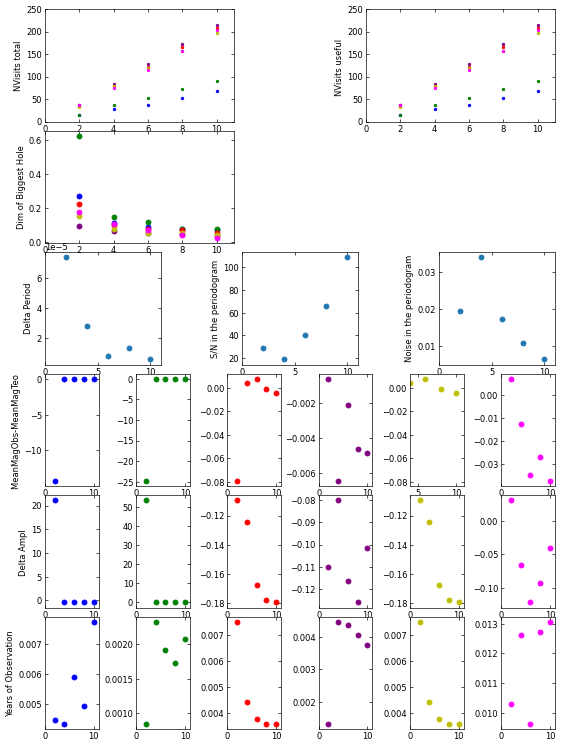

In [7]:

# Final figure of merit with most of the results summarized (one for each template, Opsim and Distance)
    
fig=plt.figure(figsize=(10,16), dpi=60)
plt.subplots_adjust(top = 0.95, bottom = 0.2, right = 0.95
                        , left = 0.1, hspace = 0.08, wspace = 0.7)

 #   fig.suptitle('RR in LMC in baseline')

ax1 = plt.subplot2grid((6,2), (0,0),  colspan=1, rowspan=1) # topleft    
ax1.set_ylabel('NVisits total')
ax1.set_xlim([0,11])
ax1.set_ylim([0,250])
ax1.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')
ax1.plot(array_year_finish,n_obs_u,'.',c=colors['u'])
ax1.plot(array_year_finish,n_obs_g,'.',c=colors['g'])
ax1.plot(array_year_finish,n_obs_r,'.',c=colors['r'])
ax1.plot(array_year_finish,n_obs_i,'.',c=colors['i'])
ax1.plot(array_year_finish,n_obs_z,'.',c=colors['z'])
ax1.plot(array_year_finish,n_obs_y,'.',c=colors['y'])
    
ax2 = plt.subplot2grid((6,2), (0,1),  colspan=1, rowspan=1) # topleft    
ax2.set_ylabel('NVisits useful ')
ax2.set_xlim([0,11])
ax2.set_ylim([0,250])
ax2.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')
ax2.plot(array_year_finish,nns_obs_u,'.',c=colors['u'])
ax2.plot(array_year_finish,nns_obs_g,'.',c=colors['g'])
ax2.plot(array_year_finish,nns_obs_r,'.',c=colors['r'])
ax2.plot(array_year_finish,nns_obs_i,'.',c=colors['i'])
ax2.plot(array_year_finish,nns_obs_z,'.',c=colors['z'])
ax2.plot(array_year_finish,nns_obs_y,'.',c=colors['y'])
    
ax3 = plt.subplot2grid((6,3), (2,0),  colspan=1, rowspan=1) # topleft    
ax3.set_ylabel('Delta Period')
ax3.set_xlim([0,11])
ax3.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax3.plot(array_year_finish,diff_array,'o')

    
ax4 = plt.subplot2grid((6,3), (2,1),  colspan=1, rowspan=1) # topleft    
ax4.set_ylabel('S/N in the periodogram')
ax4.set_xlim([0,11])
ax4.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax4.plot(array_year_finish,peak_snr_array,'o')
    
ax5 = plt.subplot2grid((6,3), (2,2),  colspan=1, rowspan=1) # topleft    
ax5.set_ylabel('Noise in the periodogram')
ax5.set_xlim([0,11])
ax5.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax5.plot(array_year_finish,noise_array,'o')
    
   
ax6 = plt.subplot2grid((6,6), (3,0),  colspan=1, rowspan=1) # topleft    
ax6.set_ylabel('MeanMagObs-MeanMagTeo ')
ax6.set_xlim([0,11])
ax6.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax6.plot(array_year_finish,DeltaMean_u_array,'o',c=colors['u'])
    #ax6.set_ylim([-0.1, 0.12])
    
    
ax7 = plt.subplot2grid((6,6), (3,1),  colspan=1, rowspan=1) # topleft    
   # ax7.set_ylabel('Delta Mean g ')
ax7.set_xlim([0,11])
ax7.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax7.plot(array_year_finish,DeltaMean_g_array,'o',c=colors['g'])
   # ax7.yaxis.set_major_formatter(plt.NullFormatter())
   # ax7.set_ylim([-0.1, 0.12])
    
ax8 = plt.subplot2grid((6,6), (3,2),  colspan=1, rowspan=1) # topleft    
#    ax8.set_ylabel('Delta Mean r ')
ax8.set_xlim([0,11])
ax8.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax8.plot(array_year_finish,DeltaMean_r_array,'o',c=colors['r'])
   # ax8.yaxis.set_major_formatter(plt.NullFormatter())
   # ax8.set_ylim([-0.1, 0.12])
    
ax9 = plt.subplot2grid((6,6), (3,3),  colspan=1, rowspan=1) # topleft    
#    ax9.set_ylabel('Delta Mean i ')
ax9.set_xlim([0,11])
ax9.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax9.plot(array_year_finish,DeltaMean_i_array,'o',c=colors['i'])
   # ax9.yaxis.set_major_formatter(plt.NullFormatter())
   # ax9.set_ylim([-0.1, 0.12])
    
ax10 = plt.subplot2grid((6,6), (3,4),  colspan=1, rowspan=1) # topleft    
#    ax10.set_ylabel('Delta Mean z ')
ax10.set_xlim([4,11])
ax10.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax10.plot(array_year_finish,DeltaMean_r_array,'o',c=colors['z'])
    #ax10.yaxis.set_major_formatter(plt.NullFormatter())
    #ax10.set_ylim([-0.1, 0.12])
    
ax11 = plt.subplot2grid((6,6), (3,5),  colspan=1, rowspan=1) # topleft    
#    ax11.set_ylabel('Delta Mean y')
ax11.set_xlim([0,11])
#ax11.set_ylim([-1, 1])
ax11.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax11.plot(array_year_finish,DeltaMean_y_array,'o',c=colors['y'])

ax17 = plt.subplot2grid((6,6), (4,0),  colspan=1, rowspan=1) # topleft    
ax17.set_ylabel('Delta Ampl ')
ax17.set_xlim([0,11])
ax17.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax17.plot(array_year_finish,DeltaAmpl_u_array,'o',c=colors['u'])
   # ax17.set_ylim([-0.2, 0.2])
    
ax12 = plt.subplot2grid((6,6), (4,1),  colspan=1, rowspan=1) # topleft    
#    ax12.set_ylabel('Delta Ampl g ')
ax12.set_xlim([0,11])
ax12.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax12.plot(array_year_finish,DeltaAmpl_g_array,'o',c=colors['g'])
   # ax12.yaxis.set_major_formatter(plt.NullFormatter())
   # ax12.set_ylim([-0.2, 0.2])
    
ax13 = plt.subplot2grid((6,6), (4,2),  colspan=1, rowspan=1) # topleft    
#    ax13.set_ylabel('Delta Ampl r ')
ax13.set_xlim([0,11])
ax13.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax13.plot(array_year_finish,DeltaAmpl_r_array,'o',c=colors['r'])
   # ax13.yaxis.set_major_formatter(plt.NullFormatter())
   # ax13.set_ylim([-0.2, 0.2])
    
ax14 = plt.subplot2grid((6,6), (4,3),  colspan=1, rowspan=1) # topleft    
#    ax14.set_ylabel('Delta Ampl i ')
ax14.set_xlim([0,11])
ax14.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax14.plot(array_year_finish,DeltaAmpl_i_array,'o',c=colors['i'])
    #ax14.yaxis.set_major_formatter(plt.NullFormatter())
    #ax14.set_ylim([-0.2, 0.2])
    
ax15 = plt.subplot2grid((6,6), (4,4),  colspan=1, rowspan=1) # topleft    
#    ax15.set_ylabel('Delta Ampl z ')
ax15.set_xlim([0,11])
ax15.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax15.plot(array_year_finish,DeltaAmpl_r_array,'o',c=colors['z'])
    #ax15.yaxis.set_major_formatter(plt.NullFormatter())
    #ax15.set_ylim([-0.2, 0.2])
    
ax16 = plt.subplot2grid((6,6), (4,5),  colspan=1, rowspan=1) # topleft    
#    ax16.set_ylabel('Delta Ampl y')
ax16.set_xlim([0,11])
ax16.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax16.plot(array_year_finish,DeltaAmpl_y_array,'o',c=colors['y'])
    #ax16.yaxis.set_major_formatter(plt.NullFormatter())
    #ax16.set_ylim([-0.2, 0.2])
    
ax18 = plt.subplot2grid((6,6), (5,0),  colspan=1, rowspan=1) # topleft    
ax18.set_ylabel('Chi ')
ax18.set_xlim([0,11])
ax18.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax18.plot(array_year_finish,Chi_u_array,'o',c=colors['u'])
    #ax18.set_ylim([-0.2, 0.2])
    
ax19 = plt.subplot2grid((6,6), (5,1),  colspan=1, rowspan=1) # topleft    
#    ax19.set_ylabel('Chi g ')
ax19.set_xlim([0,11])
ax19.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax19.plot(array_year_finish,Chi_g_array,'o',c=colors['g'])
   # ax19.yaxis.set_major_formatter(plt.NullFormatter())
   # ax19.set_ylim([-0.2, 0.2])
    
ax20 = plt.subplot2grid((6,6), (5,2),  colspan=1, rowspan=1) # topleft    
#    ax20.set_ylabel('Chi r ')
ax18.set_ylabel('Years of Observation')
ax20.set_xlim([0,11])
ax20.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax20.plot(array_year_finish,Chi_r_array,'o',c=colors['r'])
   # ax20.yaxis.set_major_formatter(plt.NullFormatter())
   # ax20.set_ylim([-0.2, 0.2])XS
    
ax21 = plt.subplot2grid((6,6), (5,3),  colspan=1, rowspan=1) # topleft    
 #   ax21.set_ylabel('Chi i ')
ax21.set_xlim([0,11])
ax21.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax21.plot(array_year_finish,Chi_i_array,'o',c=colors['i'])
   # ax21.yaxis.set_major_formatter(plt.NullFormatter())
   # ax21.set_ylim([-0.2, 0.2])
    
ax22 = plt.subplot2grid((6,6), (5,4),  colspan=1, rowspan=1) # topleft    
#    ax22.set_ylabel('Chi z ')
ax22.set_xlim([0,11])
ax22.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax22.plot(array_year_finish,Chi_r_array,'o',c=colors['z'])
   # ax22.yaxis.set_major_formatter(plt.NullFormatter())
   # ax22.set_ylim([-0.2, 0.2])
    
ax23 = plt.subplot2grid((6,6), (5,5),  colspan=1, rowspan=1) # topleft    
#    ax23.set_ylabel('Chi y')
ax23.set_xlim([0,11])
ax23.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax23.plot(array_year_finish,Chi_y_array,'o',c=colors['y'])
    #ax23.yaxis.set_major_formatter(plt.NullFormatter())
    #ax23.set_ylim([-0.2, 0.2])
    
    
#ax24 = plt.subplot2grid((6,2), (1,0),  colspan=1, rowspan=1) # topleft    
#ax24.set_ylabel('Number of Hole > Mean')
#ax24.set_xlim([0,11])
#ax24.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
#ax24.plot(array_year_finish,N_hole_u_array,'o')


ax25 = plt.subplot2grid((6,2), (1,0),  colspan=1, rowspan=1) # topleft    
ax25.set_ylabel('Dim of Biggest Hole')
ax25.set_xlim([0,11])
ax25.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in',which='major')   
ax25.plot(array_year_finish,holeDim_u_array,'o',c=colors['u'])
ax25.plot(array_year_finish,holeDim_g_array,'o',c=colors['g'])
ax25.plot(array_year_finish,holeDim_r_array,'o',c=colors['r'])
ax25.plot(array_year_finish,holeDim_i_array,'o',c=colors['i'])
ax25.plot(array_year_finish,holeDim_z_array,'o',c=colors['z'])
ax25.plot(array_year_finish,holeDim_y_array,'o',c=colors['y'])




plt.savefig(str(outDir)+'/summary_allyears.pdf')

print('DeltaMeanMagnitude')
print(DeltaMean_u_array)
print(DeltaMean_g_array)
print(DeltaMean_r_array)
print(DeltaMean_i_array)
print(DeltaMean_z_array)
print(DeltaMean_y_array)
    
    
print('Chi of the fit')
print(Chi_u_array)
print(Chi_g_array)
print(Chi_r_array)
print(Chi_i_array)
print(Chi_z_array)
print(Chi_y_array)
